Central questions: can classifiers be trained using neuroimaging meta-analysis data (i.e., coordinates, modeled activation maps, etc.). 
Goals: [1] train classifier using coordinates/modeled activation maps, [2]...

In [1]:
# Import libraries and packages.
import pandas as pd
import numpy as np
import glob
import datetime; today = datetime.date.today()
from nimare.io import convert_sleuth_to_dataset
from nimare.meta.cbma.kernel import ALEKernel
import neurosynth as ns
from neurosynth.base.dataset import Dataset
from functools import reduce

In [2]:
# Select directories and files structure.
input_prefix = str(today)
output_prefix = str(today)
in_dir = 'constructs'
out_dir = 'out'
test_dir = 'neurosynth'
# paths = glob.glob("constructs/*.txt")
paths=['constructs/saccades.txt',
      'constructs/tmind.txt',
      'constructs/pain.txt',
      'constructs/counting.txt']
print('constructs to model = {0}'.format(len(paths)))

constructs to model = 4


In [3]:
# Convert coordinates to nimare dataset. DOES NOT WORK!
datas = {}
for path in paths:
    print(path)
    datas[path[len(in_dir) + 1:-4]] = convert_sleuth_to_dataset(path)
datas.keys()  # Confirm construct keys.

constructs/saccades.txt
constructs/tmind.txt
constructs/pain.txt
constructs/counting.txt


dict_keys(['saccades', 'tmind', 'pain', 'counting'])

In [4]:
print('MA maps making...\t\t@{0}'.format(str(datetime.datetime.now())))
ma_maps_arrs = {}
for data in datas.keys():
    kern = ALEKernel()
    ma_maps = kern.transform(datas[data])  # Compute MA maps (len = ???)
    ma_maps_arrs[data] = []
    for i in np.arange(0, len(ma_maps)):
        ma_maps_arrs[data].append(np.ravel(ma_maps[i].get_data(), order='C'))
    labels = pd.DataFrame(index=datas[data].ids)
print('MA maps done!\t\t\t@{0}'.format(str(datetime.datetime.now())))

MA maps making...		@2019-08-08 15:26:30.590613
MA maps done!			@2019-08-08 15:26:41.994203


In [5]:
keys = list(datas.keys())
dataframes = {}
key = {}
for i in np.arange(0, len(keys)):
    key[keys[i]] = i
    arr = np.asarray(ma_maps_arrs[keys[i]])
    # rescale so that the maximum value in every row is 1, to match the scaling of neurosynth data
    transformed_arr = arr/arr.max(axis=1)[:,None]
    dataframes[i] = pd.DataFrame(transformed_arr)
    dataframes[i]['y'] = i

In [6]:
train_data = pd.concat([dataframes[0], dataframes[1]], ignore_index=True)
for i in np.arange(2, len(keys)):
    train_data = pd.concat([train_data, dataframes[i]], ignore_index=True)
train_data

,0,1,2,3,4,5,6,7,8,9,...,902620,902621,902622,902623,902624,902625,902626,902627,902628,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [7]:
# get the test data: this is the meta-analysis map of Neurosynth data.
test_paths=['neurosynth/saccades.csv',
      'neurosynth/tmind.csv',
      'neurosynth/pain.csv',
      'neurosynth/counting.csv']
test_dataframe = {}
for i in np.arange(0, len(keys)):
    test_dataframe[i] = pd.read_csv(test_paths[i])
    test_dataframe[i]['y'] = i
test_data = pd.concat([test_dataframe[0], test_dataframe[1]], ignore_index=True)
for i in np.arange(2, len(keys)):
    test_data = pd.concat([test_data, test_dataframe[i]], ignore_index=True)
test_data = test_data.drop('Unnamed: 0', 1)
test_data

,0,1,2,3,4,5,6,7,8,9,...,902620,902621,902622,902623,902624,902625,902626,902627,902628,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [8]:
unique_classes = np.unique(train_data['y'])

In [9]:
# now we include all classes for training, but this can be modified to include a subset of classes
train_classes = unique_classes

In [10]:
data_train_classes = train_data.loc[train_data['y'].isin(train_classes)].reset_index(drop=True)
data_test_classes = test_data.loc[test_data['y'].isin(train_classes)].reset_index(drop=True)

In [11]:
# remove voxels which are zero in all classes in the training set
zero_voxels = (data_train_classes != 0).any(axis=0).values
sub_sampled_data_train_classes = data_train_classes.loc[:, zero_voxels]
sub_sampled_data_test_classes = data_test_classes.loc[:, zero_voxels]

In [12]:
sub_sampled_data_train_classes

,93491,93492,93493,93582,93583,93672,93673,93674,93764,102954,...,798110,798190,798191,798192,798193,798281,798282,798283,798373,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.000061,0.000233,0.000725,0.000029,0.000113,0.000002,0.000012,0.000045,0.000004,6.736013e-05,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,6.882660e-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [13]:
sub_sampled_data_test_classes

,93491,93492,93493,93582,93583,93672,93673,93674,93764,102954,...,798110,798190,798191,798192,798193,798281,798282,798283,798373,y
0,-0.0,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,...,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,3


In [14]:
# use PCA to reduce dimensionality, take 100 principal components
from sklearn import decomposition
import matplotlib.pyplot as plt
pca = decomposition.PCA(n_components = 100)
y_train = sub_sampled_data_train_classes.iloc[:,-1].values
y_test = sub_sampled_data_test_classes.iloc[:,-1].values
X_train_raw = sub_sampled_data_train_classes.iloc[:,:-1].values
X_test_raw = sub_sampled_data_test_classes.iloc[:,:-1].values
pca.fit(X_train_raw)
# transform both training and test datasets
X_train = pca.transform(X_train_raw)
X_test = pca.transform(X_test_raw)

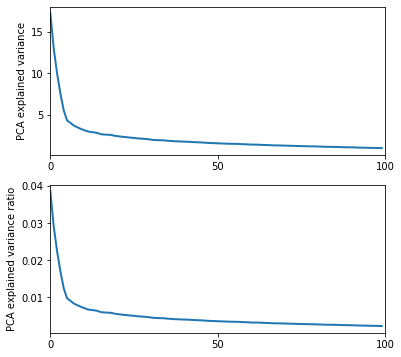

100

In [15]:
# plot the variance explained by principal components
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(6, 6))
ax0.plot(pca.explained_variance_, linewidth=2)
ax0.set_ylabel('PCA explained variance')
ax0.set_xticks(np.arange(0, 101, 50))
ax0.set_xlim([0,100])

ax1.plot(pca.explained_variance_ratio_, linewidth=2)
ax1.set_ylabel('PCA explained variance ratio')
ax1.set_xticks(np.arange(0, 101, 50))
ax1.set_xlim([0,100])
plt.show()

In [16]:
# fit two classifiers just for fun
from sklearn import svm
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
# check whether the classifiers do a decent job before training

# Linear SVM classifier
clf_svc = svm.LinearSVC(max_iter = 1000000, class_weight = 'balanced')
scores_svc = cross_val_score(clf_svc, X_train, y_train, cv=10)
print("Crossvalidated accuracy with Linear SVM classifier: %0.2f (+/- %0.2f) \n" % (scores_svc.mean(), scores_svc.std() * 2))

# Ridge classifier
clf_ridge = RidgeClassifier(alpha=100, class_weight = 'balanced')
scores_ridge = cross_val_score(clf_ridge, X_train, y_train, cv=10)
print("Crossvalidated accuracy with Ridge classifier: %0.2f (+/- %0.2f) \n" % (scores_ridge.mean(), scores_ridge.std() * 2))

# you can inspect the scores of individual classifiers by typing scores_svc, or scores_ridge

Accuracy with Linear SVM classifier: 0.62 (+/- 0.11) 

Accuracy with Ridge classifier: 0.62 (+/- 0.11) 



In [17]:
# moving on to using the above classifiers to train on brainmap data and predicting classes of neurosynth data

# Linear SVM classifier
clf_svc = svm.LinearSVC(max_iter = 1000000, class_weight = 'balanced')
clf_svc.fit(X_train, y_train)
y_predict_svc = clf_svc.predict(X_test)
svc_accuracy = len(np.where(y_test == y_predict_svc)[0])/len(y_test)
print("Accuracy of SVC classifier on meta-Neurosynth data: %0.2f \n" % (svc_accuracy))

# Sanity check: Shuffle the test data and see whether the classifier performs at chance
X_shuffle_test = X_test.copy()
y_shuffle_test = y_test.copy()
X_shuffle_test=np.tile(X_shuffle_test, (4, 1))
y_shuffle_test = np.tile(y_shuffle_test, (1,4))[0]
ignore_list_output = [np.random.shuffle(x) for x in X_shuffle_test]
y_predict_svc_shuffled = clf_svc.predict(X_shuffle_test)
svc_accuracy_shuffled = len(np.where(y_shuffle_test == y_predict_svc_shuffled)[0])/len(y_shuffle_test)
print("Accuracy of SVC classifier on shuffled meta-Neurosynth data: %0.2f \n " % (svc_accuracy_shuffled))

# Sanity check: Add noise to the test data
X_noise_test = X_test.copy()
y_noise_test = y_test.copy()
X_noise_test=np.tile(X_noise_test, (4, 1))
y_noise_test = np.tile(y_noise_test, (1,4))[0]
X_noise_test = X_noise_test + np.random.normal(0, 10, X_noise_test.shape)
y_predict_svc_noise = clf_svc.predict(X_noise_test)
svc_accuracy_noise = len(np.where(y_noise_test == y_predict_svc_noise)[0])/len(y_noise_test)
print("Accuracy of SVC classifier on noisy meta-Neurosynth data: %0.2f " % (svc_accuracy_noise))

Accuracy of SVC classifier on Neurosynth data: 1.00 

Accuracy of SVC classifier on shuffled Neurosynth data: 0.25 
 
Accuracy of SVC classifier on noisy Neurosynth data: 0.38 


In [18]:
# Ridge classifier
clf_ridge = RidgeClassifier(alpha=100, class_weight = 'balanced')
clf_ridge.fit(X_train, y_train)
y_predict_ridge = clf_ridge.predict(X_test)
ridge_accuracy = len(np.where(y_test == y_predict_ridge)[0])/len(y_test)
print("Accuracy of Ridge classifier on meta-Neurosynth data: %0.2f \n" % (ridge_accuracy))

# Sanity check: Shuffle the test data and see whether the classifier performs at chance
y_predict_ridge_shuffled = clf_ridge.predict(X_shuffle_test)
ridge_accuracy_shuffled = len(np.where(y_shuffle_test == y_predict_ridge_shuffled)[0])/len(y_shuffle_test)
print("Accuracy of Ridge classifier on shuffled meat-Neurosynth data: %0.2f \n " % (ridge_accuracy_shuffled))

# Sanity check: Add noise to the test data
y_predict_ridge_noise = clf_ridge.predict(X_noise_test)
ridge_accuracy_noise = len(np.where(y_noise_test == y_predict_ridge_noise)[0])/len(y_noise_test)
print("Accuracy of Ridge classifier on noisy meta-Neurosynth data: %0.2f " % (ridge_accuracy_noise))

Accuracy of Ridge classifier on Neurosynth data: 1.00 

Accuracy of Ridge classifier on shuffled Neurosynth data: 0.06 
 
Accuracy of Ridge classifier on noisy Neurosynth data: 0.69 


In [19]:
# lets now work with full neurosynth data instead of meta analysis maps
ns.dataset.download(path='neurosynth/', unpack=True)
dataset = Dataset('neurosynth/database.txt')
dataset.add_features('neurosynth/features.txt')
# get ids for the four different classes
ids_saccades = dataset.get_studies(features='saccades', frequency_threshold=0.001)
ids_tmind = dataset.get_studies(features='theory mind', frequency_threshold=0.001)
ids_pain = dataset.get_studies(features='pain', frequency_threshold=0.001)
ids_counting = dataset.get_studies(features='calculation*', frequency_threshold=0.001)
# get unique ids for each
ids_saccades_only = np.setdiff1d(ids_saccades, reduce(np.union1d, (ids_tmind, ids_pain, ids_counting)))
ids_tmind_only = np.setdiff1d(ids_tmind, reduce(np.union1d, (ids_saccades, ids_pain, ids_counting)))
ids_pain_only = np.setdiff1d(ids_pain, reduce(np.union1d, (ids_saccades, ids_tmind, ids_counting)))
ids_counting_only = np.setdiff1d(ids_counting, reduce(np.union1d, (ids_saccades, ids_tmind, ids_pain)))

8192  [819200.00%16384  [1638400.00%24576  [2457600.00%32768  [3276800.00%40960  [4096000.00%49152  [4915200.00%57344  [5734400.00%65536  [6553600.00%73728  [7372800.00%81920  [8192000.00%90112  [9011200.00%98304  [9830400.00%106496  [10649600.00%114688  [11468800.00%122880  [12288000.00%131072  [13107200.00%139264  [13926400.00%147456  [14745600.00%155648  [15564800.00%163840  [16384000.00%172032  [17203200.00%180224  [18022400.00%188416  [18841600.00%196608  [19660800.00%204800  [20480000.00%212992  [21299200.00%221184  [22118400.00%229376  [22937600.00%237568  [23756800.00%245760  [24576000.00%253952  [25395200.00%262144  [26214400.00%270336  [27033600.00%278528  [27852800.00%286720  [28672000.00%294912  [29491200.00%303104  [30310400.00%311296  [31129600.00%319488  [31948800.00%327680  [32768000.00%335872  [33587200.00%344064  [34406400.00%352256  [35225600.00%360448  [36044800.00%368640  [36864000.00%376832  [37683200.00%385024  [38502400.00%393216  [39321600.00%401408  [40140800.

6438912  [643891200.00%]6447104  [644710400.00%]6455296  [645529600.00%]6463488  [646348800.00%]6471680  [647168000.00%]6479872  [647987200.00%]6488064  [648806400.00%]6496256  [649625600.00%]6504448  [650444800.00%]6512640  [651264000.00%]6520832  [652083200.00%]6529024  [652902400.00%]6537216  [653721600.00%]6545408  [654540800.00%]6553600  [655360000.00%]6561792  [656179200.00%]6569984  [656998400.00%]6578176  [657817600.00%]6586368  [658636800.00%]6594560  [659456000.00%]6602752  [660275200.

8249344  [824934400.00%]8257536  [825753600.00%]8265728  [826572800.00%]8273920  [827392000.00%]8282112  [828211200.00%]8290304  [829030400.00%]8298496  [829849600.00%]8306688  [830668800.00%]8314880  [831488000.00%]8323072  [832307200.00%]8331264  [833126400.00%]8339456  [833945600.00%]8347648  [834764800.00%]8355840  [835584000.00%]8364032  [836403200.00%]8372224  [837222400.00%]8380416  [838041600.00%]8388608  [838860800.00%]8396800  [839680000.00%]8404992  [840499200.00%]8413184  [841318400.

9945088  [994508800.00%]9953280  [995328000.00%]9961472  [996147200.00%]9969664  [996966400.00%]9977856  [997785600.00%]9986048  [998604800.00%]9994240  [999424000.00%]10002432  [1000243200.00%]10010624  [1001062400.00%]10018816  [1001881600.00%]10027008  [1002700800.00%]10035200  [1003520000.00%]10043392  [1004339200.00%]10051584  [1005158400.00%]10059776  [1005977600.00%]10067968  [1006796800.00%]10076160  [1007616000.00%]10084352  [1008435200.00%]10092544  [1009254400.00%]10100736  [1010073600

11624448  [1162444800.00%]11632640  [1163264000.00%]11640832  [1164083200.00%]11649024  [1164902400.00%]11657216  [1165721600.00%]11665408  [1166540800.00%]11673600  [1167360000.00%]11681792  [1168179200.00%]11689984  [1168998400.00%]11698176  [1169817600.00%]11706368  [1170636800.00%]11714560  [1171456000.00%]11722752  [1172275200.00%]11730944  [1173094400.00%]11739136  [1173913600.00%]11747328  [1174732800.00%]11755520  [1175552000.00%]11763712  [1176371200.00%]11771904  [1177190400.00%]

13672448  [1367244800.00%]13680640  [1368064000.00%]13688832  [1368883200.00%]13697024  [1369702400.00%]13705216  [1370521600.00%]13713408  [1371340800.00%]13721600  [1372160000.00%]13729792  [1372979200.00%]13737984  [1373798400.00%]13746176  [1374617600.00%]13754368  [1375436800.00%]13762560  [1376256000.00%]13770752  [1377075200.00%]13778944  [1377894400.00%]13787136  [1378713600.00%]13795328  [1379532800.00%]13803520  [1380352000.00%]13811712  [1381171200.00%]13819904  [1381990400.00%]

15286272  [1528627200.00%]15294464  [1529446400.00%]15302656  [1530265600.00%]15310848  [1531084800.00%]15319040  [1531904000.00%]15327232  [1532723200.00%]15335424  [1533542400.00%]15343616  [1534361600.00%]15351808  [1535180800.00%]15360000  [1536000000.00%]15368192  [1536819200.00%]15376384  [1537638400.00%]15384576  [1538457600.00%]15392768  [1539276800.00%]15400960  [1540096000.00%]15409152  [1540915200.00%]15417344  [1541734400.00%]15425536  [1542553600.00%]15433728  [1543372800.00%]

17260544  [1726054400.00%]17268736  [1726873600.00%]17276928  [1727692800.00%]17285120  [1728512000.00%]17293312  [1729331200.00%]17301504  [1730150400.00%]17309696  [1730969600.00%]17317888  [1731788800.00%]17326080  [1732608000.00%]17334272  [1733427200.00%]17338397  [1733839700.00%]

/Users/Bharath/anaconda3/envs/py37/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/Users/Bharath/anaconda3/envs/py37/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()
/Users/Bharath/anaconda3/envs/py37/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/Bharath/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:808: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc

In [20]:
# get the neurosynth data for each of these unque conditions
ids = list([ids_saccades_only, ids_tmind_only, ids_pain_only, ids_counting_only])
neurosynth_dataframes = {}
k = 0
for id in np.arange(0, len(ids)):
    this_img_data = dataset.get_image_data(ids[id])
    data_array = dataset.masker.unmask(this_img_data)
    if data_array.size > 0:
        this_img_array = []
        for i in np.arange(0, data_array.shape[-1]):
            this_img_array.append((np.ravel(data_array[:,:,:,i], order='C').T))
        neurosynth_dataframes[k] = pd.DataFrame(this_img_array)
        neurosynth_dataframes[k]['y'] = id
        k = k + 1

neurosynth_data = pd.concat([neurosynth_dataframes[0], neurosynth_dataframes[1]], ignore_index=True)
for i in np.arange(2, k):
    neurosynth_data = pd.concat([neurosynth_data, neurosynth_dataframes[i]], ignore_index=True)
neurosynth_data

,0,1,2,3,4,5,6,7,8,9,...,902620,902621,902622,902623,902624,902625,902626,902627,902628,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [21]:
data_test_neurosynth = neurosynth_data.loc[neurosynth_data['y'].isin(train_classes)].reset_index(drop=True)

In [22]:
# remove voxels which are zero in all classes in the training set
sub_sampled_data_test_neurosynth = data_test_neurosynth.loc[:, zero_voxels]
sub_sampled_data_test_neurosynth

,93491,93492,93493,93582,93583,93672,93673,93674,93764,102954,...,798110,798190,798191,798192,798193,798281,798282,798283,798373,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [23]:
y_test = sub_sampled_data_test_neurosynth.iloc[:,-1].values
X_test_raw = sub_sampled_data_test_neurosynth.iloc[:,:-1].values
# transform test dataset
X_test = pca.transform(X_test_raw)

In [24]:
# use the above classifiers to predict classes of neurosynth data

# Linear SVM classifier
y_predict_svc = clf_svc.predict(X_test)
svc_accuracy = len(np.where(y_test == y_predict_svc)[0])/len(y_test)
print("Accuracy of SVC classifier on Neurosynth data with unique labels: %0.2f \n" % (svc_accuracy))

# Ridge classifier
y_predict_ridge = clf_ridge.predict(X_test)
ridge_accuracy = len(np.where(y_test == y_predict_ridge)[0])/len(y_test)
print("Accuracy of Ridge classifier on Neurosynth data with unique labels: %0.2f \n" % (ridge_accuracy))

Accuracy of SVC classifier on Neurosynth data with unique labels: 0.67 

Accuracy of Ridge classifier on Neurosynth data with unique labels: 0.66 



In [25]:
# get the neurosynth data for each of these unque conditions
ids = list([ids_saccades, ids_tmind, ids_pain, ids_counting])
neurosynth_dataframes = {}
k = 0
for id in np.arange(0, len(ids)):
    this_img_data = dataset.get_image_data(ids[id])
    data_array = dataset.masker.unmask(this_img_data)
    if data_array.size > 0:
        this_img_array = []
        for i in np.arange(0, data_array.shape[-1]):
            this_img_array.append((np.ravel(data_array[:,:,:,i], order='C').T))
        neurosynth_dataframes[k] = pd.DataFrame(this_img_array)
        neurosynth_dataframes[k]['y'] = id
        k = k + 1

neurosynth_data = pd.concat([neurosynth_dataframes[0], neurosynth_dataframes[1]], ignore_index=True)
for i in np.arange(2, k):
    neurosynth_data = pd.concat([neurosynth_data, neurosynth_dataframes[i]], ignore_index=True)
neurosynth_data

,0,1,2,3,4,5,6,7,8,9,...,902620,902621,902622,902623,902624,902625,902626,902627,902628,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [26]:
data_test_neurosynth = neurosynth_data.loc[neurosynth_data['y'].isin(train_classes)].reset_index(drop=True)

In [27]:
# remove voxels which are zero in all classes in the training set
sub_sampled_data_test_neurosynth = data_test_neurosynth.loc[:, zero_voxels]
sub_sampled_data_test_neurosynth

,93491,93492,93493,93582,93583,93672,93673,93674,93764,102954,...,798110,798190,798191,798192,798193,798281,798282,798283,798373,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [28]:
y_test = sub_sampled_data_test_neurosynth.iloc[:,-1].values
X_test_raw = sub_sampled_data_test_neurosynth.iloc[:,:-1].values
# transform test dataset
X_test = pca.transform(X_test_raw)

In [29]:
# use the above classifiers to predict classes of neurosynth data

# Linear SVM classifier
y_predict_svc = clf_svc.predict(X_test)
svc_accuracy = len(np.where(y_test == y_predict_svc)[0])/len(y_test)
print("Accuracy of SVC classifier on Neurosynth data: %0.2f \n" % (svc_accuracy))

# Ridge classifier
y_predict_ridge = clf_ridge.predict(X_test)
ridge_accuracy = len(np.where(y_test == y_predict_ridge)[0])/len(y_test)
print("Accuracy of Ridge classifier on Neurosynth data: %0.2f \n" % (ridge_accuracy))

Accuracy of SVC classifier on Neurosynth data: 0.67 

Accuracy of Ridge classifier on Neurosynth data: 0.65 

